In [2]:
import numpy as np
from scipy.signal import butter, lfilter
from sklearn.cross_decomposition import CCA
from operator import itemgetter
import matplotlib.pyplot as plt
import math

In [2]:
x = np.load('luciano_db.npy')

In [133]:
step = 5
sr = 256
target_freqs = [6,10,8,15]
data_length = sr*5-30


def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
    
def get_corr(data_eeg, model_signals):
    cca = CCA(n_components=1)
    len_result = model_signals.shape[0]
    results = dict(zip(target_freqs,np.zeros(len_result)))

    for index in np.arange(len_result):
        #model_signal_temp = model_signals[index].reshape(-1,1)
        cca.fit(data_eeg.T, model_signals[index,:,:].T)
        O1_a,O1_b = cca.transform(data_eeg.T, model_signals[index,:,:].T)
        results[target_freqs[index]] = np.corrcoef(O1_a[:,0],O1_b[:,0])[0,1]
    
    return results

def getReferenceSignal(length, target_freq, samplingRate):
    # generate sinusoidal reference templates for CCA for the first and second harmonics
    reference_signals = []
    t = np.arange(0, (length/(samplingRate)), step=1.0/(samplingRate))
    #First harmonics/Fundamental freqeuncy
    reference_signals.append(np.sin(np.pi*2*target_freq*t))
    reference_signals.append(np.cos(np.pi*2*target_freq*t))
    #Second harmonics
    reference_signals.append(np.sin(np.pi*4*target_freq*t))
    reference_signals.append(np.cos(np.pi*4*target_freq*t))
    reference_signals = np.array(reference_signals)
    return reference_signals

def getReferenceSignals(length_signal):
    freq1 = getReferenceSignal(length_signal,target_freqs[0],sr)
    freq2 = getReferenceSignal(length_signal,target_freqs[1],sr)
    freq3 = getReferenceSignal(length_signal,target_freqs[2],sr)
    freq4 = getReferenceSignal(length_signal,target_freqs[3],sr)
    freqs = np.array([freq1,freq2,freq3,freq4])
    
    return freqs

def Preprocessing(data):
    xs = np.squeeze(data)
    xs = xs.T

    ref = xs[2][30:]
    xs_O2 = xs[10][30:] - ref
    xs_Oz = xs[15][30:] - ref
    xs_POz = xs[14][30:] - ref
    xs_PO4 = xs[13][30:] - ref
    xs_PO3 = xs[12][30:] - ref


    #xs_O1_mean = xs_O1 - np.mean(xs_O1)
    xs_O2_mean = xs_O2 - np.mean(xs_O2)
    xs_Oz_mean = xs_Oz - np.mean(xs_Oz)
    xs_POz_mean = xs_POz - np.mean(xs_POz)
    xs_PO3_mean = xs_PO3 - np.mean(xs_PO3)
    xs_PO4_mean = xs_PO4 - np.mean(xs_PO4)

    #xs_O1_norm = (xs_O1_mean-np.min(xs_O1_mean))/(np.max(xs_O1_mean)-np.min(xs_O1_mean))
    xs_O2_norm = (xs_O2_mean-np.min(xs_O2_mean))/(np.max(xs_O2_mean)-np.min(xs_O2_mean))
    xs_Oz_norm = (xs_Oz_mean-np.min(xs_Oz_mean))/(np.max(xs_Oz_mean)-np.min(xs_Oz_mean))
    xs_POz_norm = (xs_POz_mean-np.min(xs_POz_mean))/(np.max(xs_POz_mean)-np.min(xs_POz_mean))
    xs_PO3_norm = (xs_PO3_mean-np.min(xs_PO3_mean))/(np.max(xs_PO3_mean)-np.min(xs_PO3_mean))
    xs_PO4_norm = (xs_PO4_mean-np.min(xs_PO4_mean))/(np.max(xs_PO4_mean)-np.min(xs_PO4_mean))

    data_eeg_norm = np.array([xs_Oz_norm, xs_O2_norm, xs_PO3_norm, xs_PO4_norm, xs_POz_norm])

    temp, temp2 = ventana(data_eeg_norm)

    n_ventanados_2 = round(data_length/(sr*step))-1
    n_datos_1 = int(sr*step)-30
    n_datos_2 = int(sr*step)

    temp = temp.reshape(1,5,n_datos_1)
    if temp2.size>0:
        temp2 = temp2.reshape(n_ventanados_2,5,n_datos_2)

    temp = filtrado(temp)
    if temp2.size>0:
        temp2 = filtrado(temp2)
    
    return temp, temp2

def getMaxFreq(corr):
        return max(corr.items(), key=itemgetter(1))[0]

def ventana(data):
    all_data1 = []
    all_data2 = []
    for index in range(data.shape[0]):
        temp = []
        temp2 = []
        for steps in range(round(len(data[index])/(sr*step))):
            if(steps==0):
                temp.append(data[index][int(sr*step*steps):int(sr*step*(steps+1))-30])
            else:
                if step<3:
                    temp2.append(data[index][int(sr*step*steps)-30:int(sr*step*(steps+1))-30])
        all_data1.append(temp)
        if temp2:
            all_data2.append(temp2)
    return np.array(all_data1), np.array(all_data2)

def filtrado(data):
    data_filtered = []
    for index in range(data.shape[0]):
        temp = []
        for index_electrode in range(data[index].shape[0]):
            temp2 = bandpass_filter(data[index][index_electrode],5,32,256,9)
            temp.append(temp2)
        data_filtered.append(temp)
    
    return np.array(data_filtered)

def getAcc(data):
    num_aciertos = 0
    num_aciertos_freqs = [0,0,0,0]
    num_pruebas = len(data)
    num_ventanado = 0
    for index in range(num_pruebas):
        data_temp, data_temp2 = Preprocessing(data[index])
        if data_temp2.size>0:
            num_ventanado = data_temp.shape[0] + data_temp2.shape[0]
            referenceSignals2 = getReferenceSignals(data_temp2.shape[2])
        else:
            num_ventanado = data_temp.shape[0]
        referenceSignals = getReferenceSignals(data_temp.shape[2])
        for ventanado_index in range(data_temp.shape[0]):
            vent = data_temp[ventanado_index]
            res = get_corr(vent, referenceSignals)
            freq_predicha = getMaxFreq(res)
            if(freq_predicha == target_freqs[index%4]):
                num_aciertos += 1
                num_aciertos_freqs[index%4] += 1
        if data_temp2.size>0:
            for ventanado_index in range(data_temp2.shape[0]):
                vent = data_temp2[ventanado_index]
                res = get_corr(vent, referenceSignals2)
                freq_predicha = getMaxFreq(res)
                if(freq_predicha == target_freqs[index%4]):
                    num_aciertos += 1
                    num_aciertos_freqs[index%4] += 1        
    print(f'{num_aciertos_freqs}')
    return num_aciertos/(num_pruebas*num_ventanado)*100

In [134]:
x = np.load('luciano_db.npy')
p = getAcc(x)
p

[15, 15, 14, 15]


98.33333333333333

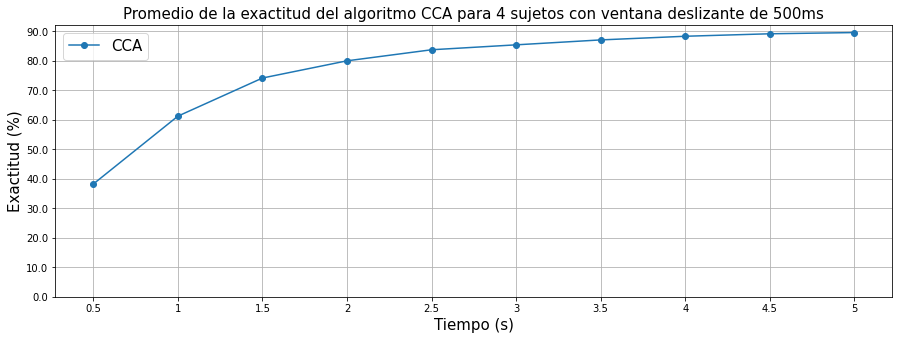

array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.])

In [3]:
data = [38.25, 61.25, 74.17, 80, 83.75, 85.42, 87.09, 88.33, 89.17, 89.58]
dats = np.linspace(0,90,10)
steps = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
plt.figure(figsize=(15,5))
plt.plot(steps,data,marker='o')
plt.title('Promedio de la exactitud del algoritmo CCA para 4 sujetos con ventana deslizante de 500ms', fontsize=15)
plt.xlabel('Tiempo (s)', fontsize=15)
plt.ylabel('Exactitud (%)', fontsize=15)
plt.yticks(dats,dats)
plt.xticks(steps,steps)
plt.grid()
plt.legend(['CCA'], fontsize=15)
plt.show()
dats

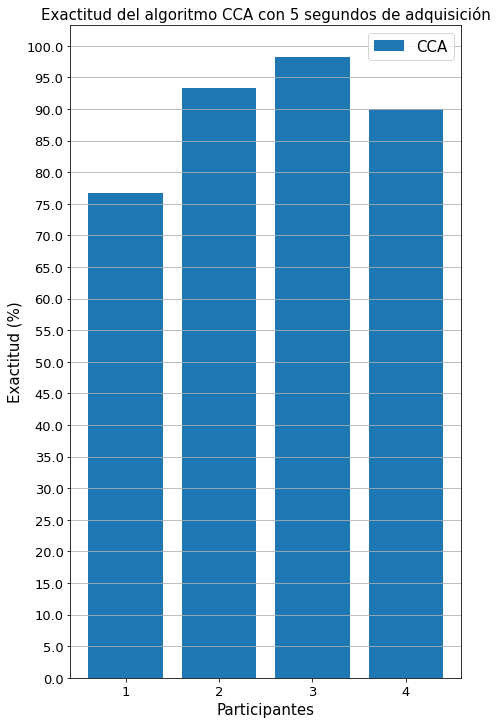

In [3]:
accs = [76.7, 93.3, 98.3, 90]
d = np.linspace(0,100,21)
pers = ['1','2','3','4']
plt.figure(figsize=(7,12))
plt.bar(pers, accs)
plt.yticks(d,d, fontsize=13)
plt.xticks(fontsize=13)
plt.title('Exactitud del algoritmo CCA con 5 segundos de adquisición',fontsize=15)
plt.ylabel('Exactitud (%)', fontsize=15)
plt.xlabel('Participantes', fontsize=15)
plt.legend(['CCA'], fontsize=15)
axes = plt.gca()
axes.yaxis.grid()
plt.show()